<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Data preprocessinge</h2>
<h3>With explorative graphs</h3>
<h4>IT University of Copenhagen, Spring 2022</h4>
<h4>Group: Nina Sand Horup & Ida Thrane</h4>
</div>

In [1]:
# import libraries needed
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd

from shapely.geometry import Point, Polygon, LineString

# libraries for plotting
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib.cm as cm



%matplotlib inline
ox.__version__

'1.0.1'

# Input parameters

In [2]:
# Plotting parameters

current_position_color = 'red'
restaurant_color = 'magenta' # limegreen
bar_color = 'darkorange'
attraction_color = 'blue'

In [3]:
# Edge cost parameters:

no_go_use = 1000
unwanted_use = 6
speed_cost = 4
anti_nature_cost = 4

# Functions

In [8]:
#Change geometries in dataframe to only be points
def gdf_to_only_points(gdf):
    gdf['geometry_init'] = gdf['geometry'] 
    gdf['geometry_init'] = gdf.loc[:, 'geometry']
    
    for i, row in gdf.iterrows():
        if row.geometry.geom_type != "Point":
            new_geometry = row.geometry.centroid
            gdf.at[i, 'geometry'] = new_geometry

In [9]:

# We have the desinations in the form of shapely points and we need the geocoordinates.
def get_coords_from_gdf(gdf):
    geometries =  gdf.geometry
    coords = []
    for geom in geometries: 
        x = geom.x
        y = geom.y
        
        coord = (y,x)
        coords.append(coord)
        
    return coords


# Which OSMIDs do these nodes correspond to, now that we have "simplified" the graph?
# Workaround to use instead of osmnx.distance.nearest_nodes (unavailable in our docker image): 
# https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=digraph#osmnx.distance.nearest_nodes
# here the geodataframe comes in handy for the apply functions:

# Note that these functions are heavily inspired from the exercise 8 solutions


def get_nearest_node(input_coordinate, G):
    nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False, node_geometry=True)

    distance = nodes.apply(lambda x: np.sqrt((x.y - input_coordinate[0])**2 + (x.x - input_coordinate[1])**2) , axis = 1)
    output = distance.idxmin()
    return output


def get_nearest_nodes(input_coordinates, G):
    nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False, node_geometry=True)
    
    output = []
    for i in range(len(input_coordinates)):
        distances = nodes.apply(lambda x: np.sqrt((x.y - input_coordinates[i][0])**2 + (x.x - input_coordinates[i][1])**2) , axis = 1)
        nearest_node = distances.idxmin()
        output.append(nearest_node)
    return output




In [193]:
# Function to calculate nearest distance to either the big water areas or the big park areas:

def dist_to_nearest_nature(coords, water, parks):
    
    #coords = list(gdf["coordinates"])
    polygons_water = water['geometry']
    polygons_water.reset_index(inplace = True, drop = True)
    
    polygons_parks = parks['geometry']
    polygons_parks.reset_index(inplace = True, drop = True)

    
    # Lists for saving results
    min_distances_to_nature = []
    nature_with_min_dist = []
    nature_type_nearest = []
    
    # Find distance to nearest polygon
    for coord in coords:
        coord = Point(coord[1], coord[0])
        # Water
        dist_to_waters = []
        for poly in polygons_water:
            if poly.geom_type == "Polygon": # Sometimes linestrings are returned, and these cannot be used
                distance = poly.exterior.distance(coord)
                dist_to_waters.append(distance)
            
            if poly.geom_type == "MultiPolygon":
                single_poly = poly.convex_hull
                distance = single_poly.exterior.distance(coord)
                dist_to_waters.append(distance)
        dist_to_nearest_water = min(dist_to_waters)
        nearest_water = polygons_water[np.argmin(dist_to_waters)]
        
        # Park areas
        dist_to_parks = []
        
        for poly in polygons_parks:
            if poly.geom_type == "Polygon": # Sometimes linestrings are returned, and these cannot be used
                distance = poly.exterior.distance(coord)
                dist_to_parks.append(distance)
            
            if poly.geom_type == "MultiPolygon":
                single_poly = poly.convex_hull
                distance = single_poly.exterior.distance(coord)
                dist_to_parks.append(distance)
        dist_to_nearest_park = min(dist_to_parks)
        nearest_park = polygons_parks[np.argmin(dist_to_parks)]
        
        # Both
        dist_to_nearest_nature = min(dist_to_nearest_water, dist_to_nearest_park)
        min_distances_to_nature.append(dist_to_nearest_nature)
        
        if dist_to_nearest_water < dist_to_nearest_park:
            nature_with_min_dist.append(nearest_water)
            nature_type_nearest.append("water")
        else:
            nature_with_min_dist.append(nearest_park)
            nature_type_nearest.append("park")
    
    return min_distances_to_nature, nature_with_min_dist, nature_type_nearest


**Edge cost functions**

In [11]:
def apply_road_use_cost(G, name_of_cost):
    for edge in G.edges:
        if type(G.edges[edge]["highway"]) == str: #meaning we are not dealing with a list
            current_string = G.edges[edge]["highway"]
            if current_string in no_go_road_types:
                G.edges[edge][name_of_cost] = G.edges[edge]["length"] * no_go_use
            if current_string in unwanted_road_types:
                G.edges[edge][name_of_cost] = G.edges[edge]["length"] * unwanted_use
            else: 
                G.edges[edge][name_of_cost] = 0
        if type(G.edges[edge]["highway"]) == list:
            current_set = set(G.edges[edge]["highway"])
            if current_set.intersection(no_go_road_types):
                G.edges[edge][name_of_cost] = G.edges[edge]["length"] * no_go_use
            if current_set.intersection(no_go_road_types):
                G.edges[edge][name_of_cost] = G.edges[edge]["length"] * unwanted_use
            else: 
                G.edges[edge][name_of_cost] = 0


def apply_speed_cost(G, name_of_cost):
    for edge in G.edges:
        if "maxspeed" in G.edges[edge]:
            if (type(G.edges[edge]["maxspeed"]) == list): # Here we take the biggest value, if more than one is listed
                float_list = [float(i) for i in G.edges[edge]["maxspeed"]]
                G.edges[edge][name_of_cost] = max(float_list) * speed_cost
            else: 
                G.edges[edge][name_of_cost] = float(G.edges[edge]["maxspeed"]) * speed_cost
        else:
            G.edges[edge][name_of_cost] = 0


def apply_gain_to_edges_in_polygons(G, geometries, name_of_gain):
    polygons = geometries['geometry']
    
    nodes_in_polygons = []
    
    # Find nodes in polygons with within function from shapely
    
    for node, data in G.nodes(data = True):
        coord = Point(data["x"], data["y"])
        for poly in polygons:
            if coord.within(poly):
                nodes_in_polygons.append(node)
    
    # Apply edge weight to edges with ends in any of these nodes
    for edge in G.edges:
        if (edge[0] in nodes_in_polygons) or (edge[1] in nodes_in_polygons): 
            G.edges[edge][name_of_gain] = 0
        else: 
            G.edges[edge][name_of_gain] = G.edges[edge]["length"] * anti_nature_cost
            
def apply_gain_to_edges_near_polygons(G, geometries, name_of_gain):
    polygons = geometries['geometry']
    
    nodes_near_polygons = []
    
    # Find nodes in polygons with within function from shapely
    
    for node, data in G.nodes(data = True):
        coord = Point(data["x"], data["y"])
        for poly in polygons:
            if poly.geom_type == "Polygon": # Sometimes linestrings are returned, and these cannot be used
                distance = poly.exterior.distance(coord)

                if distance < 0.0005: #If distance is less than 0.5 meters (found empirically to be good)
                    nodes_near_polygons.append(node)
            
            if poly.geom_type == "MultiPolygon":
                single_poly = poly.convex_hull
                distance = single_poly.exterior.distance(coord)

                if distance < 0.0005: #If distance is less than 0.5 meters (found empirically to be good)
                    nodes_near_polygons.append(node)
                
    # Apply edge weight to edges with ends in any of these water nodes
    for edge in G.edges:
        if (edge[0] in nodes_near_polygons) or (edge[1] in nodes_near_polygons): 
            G.edges[edge][name_of_gain] = 0
        else: 
            G.edges[edge][name_of_gain] =  G.edges[edge]["length"]* anti_nature_cost
            
def sum_edge_attributes(G, attributes):
    list_total_costs = []
    for u, v, key, data in G.edges(keys=True, data=True): 
        total_cost = 0
        for att in attributes:
            total_cost = total_cost + data[att]
        data["total_cost"] = total_cost
        list_total_costs.append(total_cost)
    return list_total_costs

**Functions for saving and reloading data**

In [12]:
def graph_cols_to_float(G, cols):
    for i, j, key, data in G.edges(keys = True, data = True):
        for col in cols:
            data[col] = float(data[col])

# Import data

### Import big area

**Network graph**

In [4]:
## Import graph data from folder

G = ox.io.load_graphml("./data/graphs/G_copenhagen")

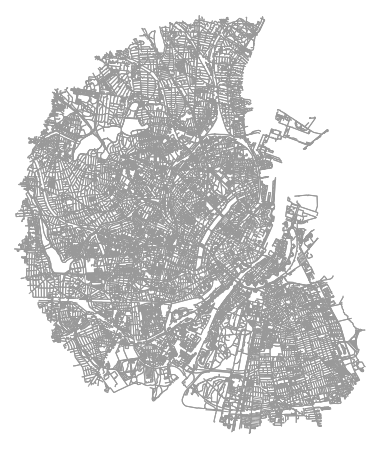

In [5]:
fig, ax = ox.plot_graph(G, node_size=0, show = False, close = False, bgcolor = "white");

plt.savefig('./plots/Copenhagen/initial_graph.png')

plt.show()


**Destinations**

In [ ]:
#Load Copenhagen data
gdf_cph= gpd.read_file("data/data_cph.json")
gdf_cph=gdf_cph.set_index("id")
gdf_cph.head()

**Water areas and parks**

In [70]:
# Import water areas
# Change this to load
#water_big = ox.geometries_from_point(copenhagen_centre, tags = water_tags, dist=max_distance_to_city_edge)

water_polygons_big = water_big["geometry"]


In [71]:
# Import parks
# Change this to load
#parks_big = ox.geometries_from_point(copenhagen_centre, tags = park_tags, dist=max_distance_to_city_edge)

parks_polygons_big = parks_big["geometry"]

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


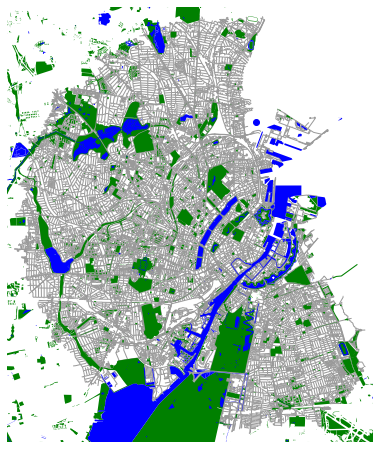

In [72]:
# Plot the water and park areas
fig, ax = ox.plot_graph(U_big, node_size=0, show=False, close=False, bgcolor = 'white');

parks_big.plot(color="green", linewidth=1, ax=ax)

water_big.plot(color="blue", linewidth=1, ax=ax)

plt.savefig('./plots/Copenhagen/water_and_parks.png')


### Import small area

In [13]:
%%time
# Import area from address using radius in meters
G_small = ox.graph_from_point(
    current_position,
    dist=small_graph_radius,
    dist_type="network",
    network_type="all",
    simplify = True
)


# We can simplify the graph further by converting to a non-directed. 
# Since the app assumes that the user is on foot (or at least on bike), the one-way roads 
# are not that important

#U_small = ox.utils_graph.get_undirected(G_small) # U is the non-directed graph.
U_small = G_small # Let's try to not simplify, so saving will be better. 
# Note that this takes extra time - does it help us later on?

CPU times: user 16.9 s, sys: 349 ms, total: 17.2 s
Wall time: 17.4 s


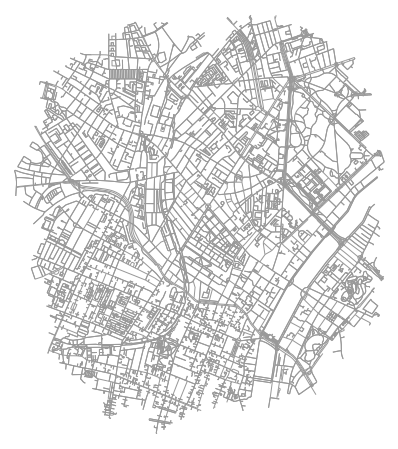

In [14]:
fig, ax = ox.plot_graph(U_small, node_size=0, show = False, close = False, bgcolor = "white");

plt.savefig('./plots/Subset/initial_graph.png')

plt.show()


**Destinations**

**Water areas and parks**

In [15]:
# Import water areas

water_small = ox.geometries_from_point(current_position, tags = water_tags, dist=small_graph_radius)

water_polygons_small = water_small["geometry"]



In [16]:
# Import parks

parks_small = ox.geometries_from_point(current_position, tags = park_tags, dist=small_graph_radius)

parks_polygons_small = parks_small["geometry"]

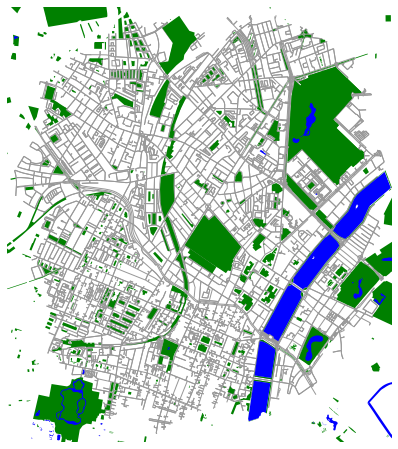

In [17]:
# Plot the water and park areas
fig, ax = ox.plot_graph(U_small, node_size=0, show=False, close=False, bgcolor = 'white');

parks_small.plot(color="green", linewidth=1, ax=ax)

water_small.plot(color="blue", linewidth=1, ax=ax)


plt.savefig('./plots/Subset/water_and_parks.png')



# Determine which to use (big/small area)

In [18]:
use = "small" # "big"     "small"


if use == "big":
    U = U_big

    water = water_big
    water_polygons = water_polygons_big

    parks = parks_big
    parks_polygons = parks_polygons_big


if use == "small":
    U = U_small

    water = water_small
    water_polygons = water_polygons_small

    parks = parks_small
    parks_polygons = parks_polygons_small


# Create subsets of water and park areas

How to calculate area from ellipsoids:

https://stackoverflow.com/questions/23697374/calculate-polygon-area-in-planar-units-e-g-square-meters-in-shapely


### Calculating water areas and making subset
We create the subsets by calculating the areas (in square-degrees) and setting a threshold.

In [19]:
area_threshold = 2e-6

In [20]:
# Calculate water areas
water_area_list = []
for poly in water_polygons: 
    area = poly.area
    water_area_list.append(area)

# Add the area information back into the geodataframe

water["area"] = water_area_list

In [21]:
# Create water subset
print("min", min(water_area_list),"max",  max(water_area_list),"mean", np.mean(water_area_list))

water_subset = water[water["area"] > area_threshold]


min 0.0 max 4.7464403254987425e-05 mean 2.5127307818378827e-06


### Calculating park areas and making subset


In [22]:

# Calculate park areas
park_area_list = []
for poly in parks_polygons:
    area = poly.area
    park_area_list.append(area)

# Add the area information back into the geodataframe

parks["area"] = park_area_list



In [23]:
# Create park subset 

print("min", min(park_area_list),"max",  max(park_area_list),"mean", np.mean(park_area_list))

parks_subset = parks[parks["area"] > area_threshold]

min 4.2833999999738956e-10 max 0.00025501229728998575 mean 1.331657767961889e-06


### Plot

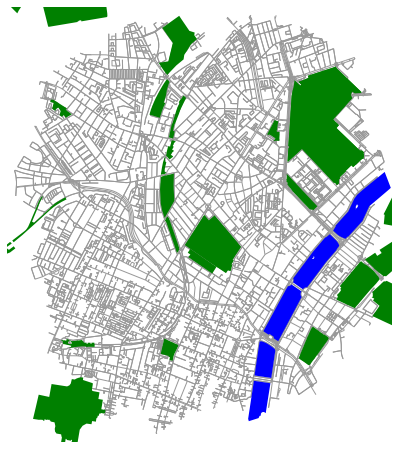

In [24]:

# Plot water subset
fig, ax = ox.plot_graph(U, node_size=0, show=False, close=False, bgcolor = 'white');

water_subset.plot(color="blue", linewidth=1, ax=ax)

parks_subset.plot(color="green", linewidth=1, ax=ax)

if use == "big":
    plt.savefig('./plots/Copenhagen/water_parks_subset.png')
    
if use == "small":
    plt.savefig('./plots/Subset/water_parks_subset.png')

# Preprocessing of destinations

### Choosing a subset of relevant tags

In [25]:
# This is just for now
restaurants = ox.geometries_from_point(current_position, tags = {"amenity": "restaurant"}, dist=points_radius_small)
bars = ox.geometries_from_point(current_position, tags = {"amenity": "bar"}, dist=points_radius_small)
attractions = ox.geometries_from_point(current_position, tags = {"tourism": True}, dist=points_radius_small)




In [119]:
# Do the real ones here

### Sorting into three categories

This sorting depends on the time of day

In [120]:
# Do that here

In [26]:
print("we end up with \n",len(restaurants), "restaurants \n", len(bars), "bars \n", len(attractions), "attractions \n")


we end up with 
 57 restaurants 
 58 bars 
 30 attractions 



In [ ]:
# Some explorative plots? 

### Change geometry to point if it is not already



In [27]:
# Applying function which changes geometries to be only points
gdf_to_only_points(restaurants)
gdf_to_only_points(bars)
gdf_to_only_points(attractions)

### Converting destinations to nodes in the graph

Later, we want to turn our geocoordinates of locations into OSM IDs.
Ideally, we would be using `osmnx.distance.nearest_nodes`. However, our docker is running an outdated OSMnx version where this function does not work (and its predecessor, ` get_nearest_node`, is deprecated). A possible, neither efficient nor elegant but enough-for-our-purposes workaround is to look for the node that minimizes euclidean distance to the location. 

Note that we still want to plot the destionation at its actual location to ensure that the user is not confused.

**Get coordinates**

In [28]:
# Get coords

restaurant_coords = get_coords_from_gdf(restaurants)
bar_coords = get_coords_from_gdf(bars)
attraction_coords = get_coords_from_gdf(attractions)

# Add coordinates back into the gdf's
restaurants["coordinates"] = restaurant_coords
bars["coordinates"] = bar_coords
attractions["coordinates"] = attraction_coords


#### Get nearest OSM ID in the graph

In [29]:
# We first convert the coordinates of our current position into a node:

current_node = get_nearest_node(current_position, U)

**Restaurants**

In [30]:
# Converting the desinations coordinates into nodes which exist on our graph
restaurant_node_ids = get_nearest_nodes(restaurant_coords, U)
restaurant_nodes_and_current_position = restaurant_node_ids + [current_node]

# Add the information back into the gdf
restaurants["nearest node"] = restaurant_node_ids


**Bars**

In [31]:
# Converting the desinations coordinates into nodes which exist on our graph
bar_node_ids = get_nearest_nodes(bar_coords, U)
bar_nodes_and_current_position = bar_node_ids + [current_node]

# Add the information back into the gdf
bars["nearest node"] = bar_node_ids


**Attractions**

In [32]:
# Converting the desinations coordinates into nodes which exist on our graph
attraction_node_ids = get_nearest_nodes(attraction_coords, U)
attraction_nodes_and_current_position = attraction_node_ids + [current_node]

# Add the information back into the gdf
attractions["nearest node"] = attraction_node_ids


**Plot**

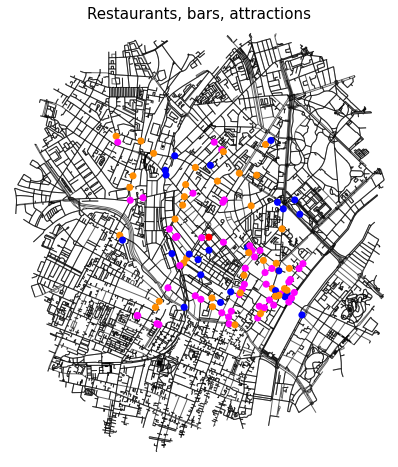

In [33]:

# create node weights 
node_weights = [50 if (node in restaurant_nodes_and_current_position) or (node in bar_nodes_and_current_position) or (node in attraction_nodes_and_current_position) else 0 for node in U.nodes]

node_colours = [current_position_color if node == current_node else restaurant_color if node in restaurant_node_ids else bar_color if node in bar_node_ids else attraction_color if node in attraction_node_ids else 'white' for node in U.nodes]


# Plot

# We plot the nodes which minimizes the distance to the coordinates to check that the method works
fig, ax = ox.plot_graph(U, node_size=node_weights, node_color = node_colours,  edge_color="black", edge_linewidth=1, edge_alpha=0.6, bgcolor = 'white', show = False, close = False);

ax.set_title("Restaurants, bars, attractions", fontsize = 15)


if use == "big":
    plt.savefig('./plots/Copenhagen/restaurants_bars_attractions.png')
    
if use == "small":
    plt.savefig('./plots/Subset/restaurants_bars_attractions.png')

plt.show()


### Get distance to nearest park/water and get subset

**Get 10 restaurants closest to nature**

In [194]:
restaurants_distances_to_nature, restaurants_nearest_nature, restaurants_nearest_nature_type = dist_to_nearest_nature(list(restaurants["coordinates"]), water_subset, parks_subset)

# Apply to gdf
restaurants["dist_to_nature"] = restaurants_distances_to_nature
restaurants["nearest_nature"] = restaurants_nearest_nature
restaurants["nearest_nature_type"] = restaurants_nearest_nature_type

print("min", min(restaurants_distances_to_nature), "max", max(restaurants_distances_to_nature), "mean", np.mean(restaurants_distances_to_nature))



min 0.00022338416882054508 max 0.0068338319377446105 mean 0.0024208682994075665


**Get 10 bars closest to nature**


In [196]:
bars_distances_to_nature, bars_nearest_nature, bars_nearest_nature_type = dist_to_nearest_nature(list(bars["coordinates"]), water_subset, parks_subset) # Do it for restaurants etc.

# Apply to gdf
bars["dist_to_nature"] = bars_distances_to_nature
bars["nearest_nature"] = bars_nearest_nature
bars["nearest_nature_type"] = bars_nearest_nature_type



**Get 10 attractions closest to nature**


In [197]:
attractions_distances_to_nature, attractions_nearest_nature, attractions_nearest_nature_type = dist_to_nearest_nature(list(attractions["coordinates"]), water_subset, parks_subset) # Do it for restaurants etc.

# Apply to gdf
attractions["dist_to_nature"] = attractions_distances_to_nature
attractions["nearest_nature"] = attractions_nearest_nature
attractions["nearest_nature_type"] = attractions_nearest_nature_type



**Get indexes**

If threshold method (only for visualization)

In [40]:
# Threshold method (good for plotting all of Copenhagen, but only for visual purposes)

threshold = 0.0020

#Restaurants 

restaurant_node_ids_nature = np.asarray([i for (i, j) in zip(restaurant_node_ids, restaurants_distances_to_nature) if j < threshold])

restaurant_node_ids_nature_and_current_position = np.append(restaurant_node_ids_nature, current_node)

print("We go from ", len(restaurant_node_ids), "restaurants to ", len(restaurant_node_ids_nature), "restaurants")

# Bars

bar_node_ids_nature = np.asarray([i for (i, j) in zip(bar_node_ids, bars_distances_to_nature) if j < threshold])

bar_node_ids_nature_and_current_position = np.append(bar_node_ids_nature, current_node)

print("We go from ", len(bar_node_ids), "restaurants to ", len(bar_node_ids_nature), "bars")


# Attractions

attraction_node_ids_nature = np.asarray([i for (i, j) in zip(attraction_node_ids, attractions_distances_to_nature) if j < threshold])

attraction_node_ids_nature_and_current_position = np.append(attraction_node_ids_nature, current_node)

print("We go from ", len(attraction_node_ids), "restaurants to ", len(attraction_node_ids_nature), "attractions")



We go from  57 restaurants to  27 restaurants
We go from  58 restaurants to  25 bars
We go from  30 restaurants to  22 attractions


If top 10:


In [41]:
# Get the indexes of the 10 destinations closest to nature: 

indexes_restaurants = np.argsort(restaurants_distances_to_nature)[:10]

restaurant_node_ids_nature = np.array(restaurant_node_ids)[indexes_restaurants] 

restaurant_node_ids_nature_and_current_position = np.append(restaurant_node_ids_nature, current_node)


# Get the indexes of the 10 bars closest to nature: 

indexes_bars = np.argsort(bars_distances_to_nature)[:10]

bar_node_ids_nature = np.array(bar_node_ids)[indexes_bars] 

bar_node_ids_nature_and_current_position = np.append(bar_node_ids_nature, current_node)



# Get the indexes of the 10 bars closest to nature: 

indexes_attractions = np.argsort(attractions_distances_to_nature)[:10]

attraction_node_ids_nature = np.array(attraction_node_ids)[indexes_attractions] 

attraction_node_ids_nature_and_current_position = np.append(attraction_node_ids_nature, current_node)




**Plot**

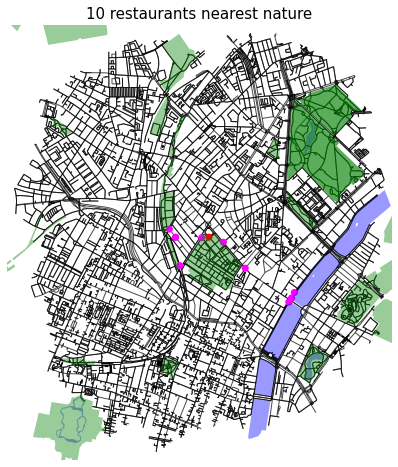

In [42]:
# Restaurants only (to be deleted)

# create node weights
restaurant_node_weights = [50 if node in restaurant_node_ids_nature_and_current_position else 0 for node in U.nodes]
restaurant_node_colors = [restaurant_color if (node in restaurant_node_ids_nature) else 'grey' if (node in restaurant_node_ids) else 'red' if node == current_node else 'white' for node in U.nodes]


# We plot the nodes which minimizes the distance to the coordinates to check that the method works
#fig, ax = ox.plot_graph(U, node_size=restaurant_node_weights, node_color = restaurant_node_colors,  edge_color="black", edge_linewidth=1, edge_alpha=0.7, bgcolor = 'white', show = False, close = False);


fig, ax = ox.plot_graph(U, node_size=restaurant_node_weights, node_color = restaurant_node_colors,  edge_color="black", edge_linewidth=1, edge_alpha=0.7, bgcolor = 'white', show = False, close = False);

water_subset.plot(color="blue", linewidth=1, ax=ax, alpha = 0.4)
parks_subset.plot(color="green", linewidth=1, ax=ax, alpha = 0.4)

ax.set_title("10 restaurants nearest nature", fontsize = 15)


plt.show()



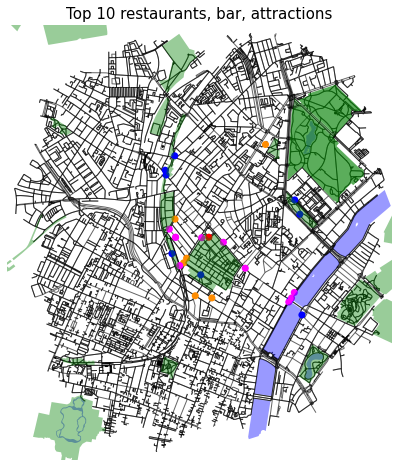

In [43]:
# Plotting all top 10 

# create node weights 
node_weights = [50 if (node in restaurant_node_ids_nature_and_current_position) or (node in bar_node_ids_nature_and_current_position) or (node in attraction_node_ids_nature_and_current_position) else 0 for node in U.nodes]

node_colours = [current_position_color if node == current_node else restaurant_color if node in restaurant_node_ids_nature else bar_color if node in bar_node_ids_nature else attraction_color if node in attraction_node_ids_nature else 'white' for node in U.nodes]

# Plot

# We plot the nodes which minimizes the distance to the coordinates to check that the method works
fig, ax = ox.plot_graph(U, node_size=node_weights, node_color = node_colours,  edge_color="black", edge_linewidth=1, edge_alpha=0.6, bgcolor = 'white', show = False, close = False);

water_subset.plot(color="blue", linewidth=1, ax=ax, alpha = 0.4)
parks_subset.plot(color="green", linewidth=1, ax=ax, alpha = 0.4)


ax.set_title("Top 10 restaurants, bar, attractions", fontsize = 15)


if use == "big":
    plt.savefig('./plots/Copenhagen/top10_restaurants_bars_attractions.png')
    
if use == "small":
    plt.savefig('./plots/Subset/top10_restaurants_bars_attractions.png')
    
plt.show()


# Preprocessing edges

In order to create nicer routes, we create route attributes which encourage the algorithm to choose routes based on other things than just the length of the route. 

We choose to use the following attributes:

- What is the primary use of the road
- What is the speed limit
- Is the edge in a green area?
- Is the edge near water?

### Road use cost

Adding cost which takes into account the use of the road

In [44]:
# Here we look at the possible uses the edges can have, so we get to know our data better

highway_types = []

for u, v, key, data in U_big.edges(keys=True, data=True): 
    highway_types.append(str(data["highway"]))

highway_list = set(highway_types)
#highway_list

NameError: name 'U_big' is not defined

The roads we for all costs want to avoid are:

- 'motorway'
- 'motorway_link'
- 'primary'
- 'primary_link'

The roads we would like to avoid are: 

- 'secondary'
- 'secondary_link'
- 'tertiary'
- 'tertiary_link'


In [45]:
# Let's make a function for applying the cost of the road use

no_go_road_types = ['motorway','motorway_link','trunk','primary','primary_link']
unwanted_road_types = ['secondary','secondary_link','tertiary','tertiary_link']


In [46]:
# Let's try to apply it using the function

apply_road_use_cost(U, "use_cost")

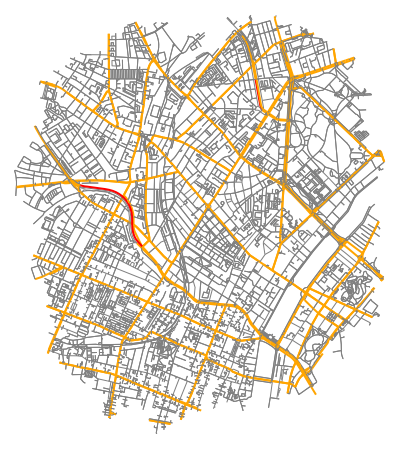

In [47]:
# Let's plot where the highway_cost is over 0 (after applying it)

highway_cost_linewidth = [2 if data["use_cost"] > 0 else 1 for u, v, key, data in U.edges(keys=True, data=True)]
highway_cost_colour = ["r" if data["use_cost"] > 2000 else "orange" if data["use_cost"] > 0 else "grey" for u, v, key, data in U.edges(keys=True, data=True)]

fig, ax = ox.plot_graph(U, node_size=0, edge_color=highway_cost_colour, edge_linewidth=highway_cost_linewidth, edge_alpha=1, bgcolor = "white", show = False, close = False)

if use == "big":
    plt.savefig('./plots/Copenhagen/road_use_cost_applied.png')
    
if use == "small":
    plt.savefig('./plots/Subset/road_use_cost_applied.png')

plt.show()
    

### Road speed cost

We add an extra cost to roads which scale with the speed limit. The reason we do this, is that the road use cost mostly targets the biggest roads, and in this way we can also target medium roads. But the cost will be smaller now than in the road use cost.

We found that the difficult part here was that sometime the max_speed is listed as a list. This is probably due to the fact that OSMnx sinplifies the network, and that some edge attributes can be concatenated into a list if they are different. We choose to just use the biggest value in the list as the ground truth. 

This is taken care of in our road speed cost function.

In [48]:
# Let's use the function

apply_speed_cost(U, "speed_cost")

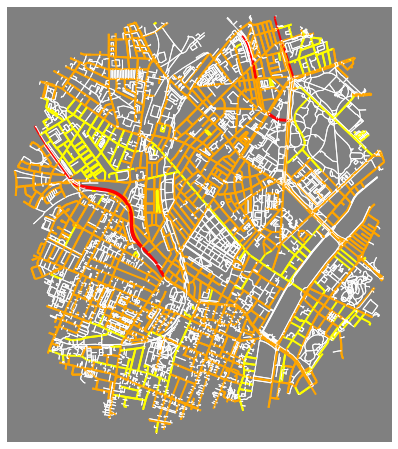

In [51]:
# Let's plot where the speed_cost is over 0 (after applying it)

highway_cost_linewidth = [2 if data["speed_cost"] > 0 else 1 for u, v, key, data in U.edges(keys=True, data=True)]
speed_cost_colour = ["yellow" if (data["speed_cost"] > 0 and data["speed_cost"] < 200) else "orange" if data["speed_cost"] == 200 else "red" if data["speed_cost"] > 50 else "w" for u, v, key, data in U.edges(keys=True, data=True)]

fig, ax = ox.plot_graph(U, node_size=0, edge_color=speed_cost_colour, edge_linewidth=highway_cost_linewidth, edge_alpha=1, bgcolor = "grey", show = False, close = False)

if use == "big":
    plt.savefig('./plots/Copenhagen/speed_use_cost_applied.png')
    
if use == "small":
    plt.savefig('./plots/Subset/speed_use_cost_applied.png')

plt.show()

### Lower cost for water and green areas



In [52]:
apply_gain_to_edges_in_polygons(U, parks, "park_gain")

In [53]:
apply_gain_to_edges_near_polygons(U, water, "water_gain")

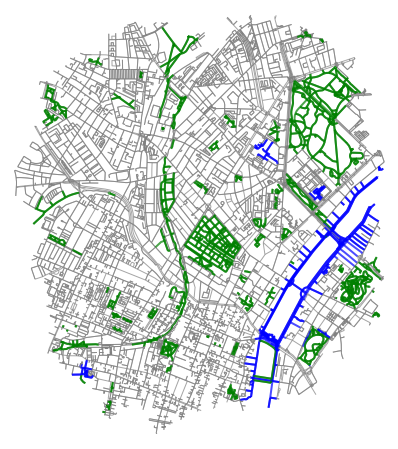

In [54]:
# Let's plot the park and water gain

park_gain_linewidth = [2 if (data["park_gain"] == 0) or (data["water_gain"] == 0) else 1 for u, v, key, data in U.edges(keys=True, data=True)]
park_gain_colour = ["green" if data["park_gain"] == 0 else "blue" if data["water_gain"] == 0 else "grey" for u, v, key, data in U.edges(keys=True, data=True)]

fig, ax = ox.plot_graph(U, node_size=0, edge_color=park_gain_colour, edge_linewidth=park_gain_linewidth, edge_alpha=0.7, bgcolor = "white", show = False, close = False)

if use == "big":
    plt.savefig('./plots/Copenhagen/park_water_gain_cost_applied.png')
    
if use == "small":
    plt.savefig('./plots/Subset/park_water_gain_cost_applied.png')

plt.show()


### Adding all the edge attributes together

In [55]:
attributes = ['length', 'use_cost', 'speed_cost', 'park_gain', 'water_gain']


In [56]:
list_total_costs = sum_edge_attributes(U, attributes)


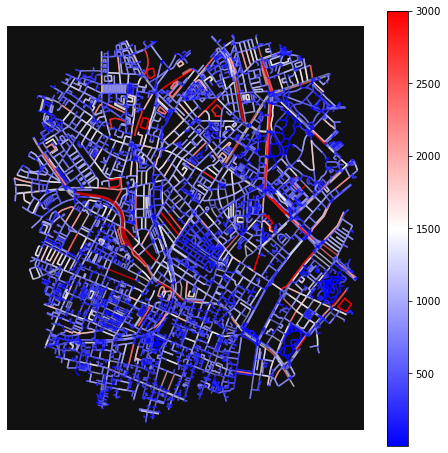

In [59]:
# Making colour scale
norm = matplotlib.colors.Normalize(vmin=min(list_total_costs), vmax=3000)
cmap = cm.bwr
m = cm.ScalarMappable(norm=norm, cmap=cmap)

edge_cost_colors = [m.to_rgba(data["total_cost"]) for u, v, key, data in U.edges(keys=True, data=True)]

# Plotting the figure
    
fig, ax = ox.plot_graph(U, node_size=0, edge_color=edge_cost_colors, edge_linewidth=1.5, edge_alpha=0.7,show=False, close=False)

fig.colorbar(m, ax = ax, orientation='vertical')
plt.show()

# Saving data

### Save graph (nodes and edged)

Note: in order for this method to work, the graph must be a Multi-di-graph and this is why we do not simplify before saving and reloading the data.

In [60]:
# Save 
ox.io.save_graphml(U, "./data/U_small/U_graph")

In [61]:
U2 = ox.io.load_graphml("./data/U_small/U_graph")

The only difference is, that the edge attributes are now loaded as strings, so we need to change them to floats. 


In [62]:
cols_to_float = ['use_cost', 'speed_cost', 'park_gain', 'water_gain', 'total_cost']


In [63]:
graph_cols_to_float(U2, cols_to_float)

In [65]:
# Making colour scale
#norm = matplotlib.colors.Normalize(vmin=min(list_total_costs), vmax=3000)
#cmap = cm.bwr
#m = cm.ScalarMappable(norm=norm, cmap=cmap)

#edge_cost_colors = [m.to_rgba(data["total_cost"]) for u, v, key, data in U2.edges(keys=True, data=True)]

# Plotting the figure
    
#fig, ax = ox.plot_graph(U2, node_size=0, edge_color=edge_cost_colors, edge_linewidth=1.5, edge_alpha=0.7,show=False, close=False)

#fig.colorbar(m, ax = ax, orientation='vertical')
#plt.show()

# Choosing three good combinations of destinations for routing

In [170]:
a = attraction_node_ids_nature
b = bar_node_ids_nature
c = restaurant_node_ids_nature

In [187]:
a_b_c = np.append(a, np.append(b, c))

#### Make list of all possible permutations: 

In [171]:
all_permutations = []

for i in range(len(a)):
    for j in range(len(b)):
        for k in range(len(c)):
            #print(i,j,k)

            all_permutations.append((i,j,k))

print(len(all_permutations))


1000


#### Remove routes where points are too close or too far

Stop if we get to less than 20 routes

In [172]:
from pyproj import Geod
geod = Geod(ellps="WGS84")


In [217]:
irrelevant_permutations = []
relevant_permutations = []

for i in range(len(a)):
    #print("i", i)
    
    node1 = a[i]
    point1 = Point(U.nodes[node1]["y"], U.nodes[node1]["x"])
    
    for j in range(len(b)):
        #print("j", j)
        
        node2 = b[j]
        point2 = Point(U.nodes[node2]["y"], U.nodes[node2]["x"])
        
        line_string12 = LineString([point1, point2])
        dist12 = geod.geometry_length(line_string12)
        #print(dist12)
        for k in range(len(c)):
            #print("k", k)
            #print(i,j,k)
            
            node3 = c[k]
            point3 = Point(U.nodes[node3]["y"], U.nodes[node3]["x"])
            
            line_string13 = LineString([point1, point3])
            dist13 = geod.geometry_length(line_string13)
            line_string23 = LineString([point2, point3])
            dist23 = geod.geometry_length(line_string23)
            
            if len(all_permutations) - len(irrelevant_permutations) > 15:
                if (dist12 > 300) and (dist12 < 1500) and (dist13 > 300) and (dist13 < 1500) and (dist23 > 300) and (dist23 < 1500):
                    relevant_permutations.append([node1,node2,node3])
                else: 
                    irrelevant_permutations.append([node1,node2,node3])
            else:
                relevant_permutations.append([node1,node2,node3])


In [273]:
if len(relevant_permutations) < 16:
    final_routes = relevant_permutations

#### Cherrypick routes based on nature data

Only do this step if we have more than 15 routes

Steps: 
- only include routes which are close to both water and park
- if the upper condition renders less than 15 routes, we pick a random subset of other routes untill we have 15 candidates. 

In [271]:
# Make a subset of U which only contains the top-10 restaurants, bars and attractions

if len(relevant_permutations) > 15:
    U_nodes_subset = []
    U_nodes_data_subset = []

    for node in U.nodes:
        if node in a_b_c:
            U_nodes_subset.append(node)
            U_nodes_data_subset.append(U.nodes[node])

    U_subset_coords = []
    for data in U_nodes_data_subset:
        tup = (data["y"], data["x"])
        U_subset_coords.append(tup)

    # Get nearest nature for all nodes in this subset:

    U_subset_distances_to_nature, U_subset_nearest_nature, U_subset_nearest_nature_type = dist_to_nearest_nature(U_subset_coords, water_subset, parks_subset) 

    # Get routes where nature type differs
    nature_type_permutations = []
    non_nature_type_permutations = []

    for i in relevant_permutations:
        a_r = i[0]
        a_index = np.ravel(np.where(np.asarray(U_nodes_subset)==a_r))[0]
        a_nature_type = U_subset_nearest_nature_type[a_index]

        b_r = i[1]
        b_index = np.ravel(np.where(np.asarray(U_nodes_subset)==b_r))[0]
        b_nature_type = U_subset_nearest_nature_type[b_index]

        c_r = i[2]
        c_index = np.ravel(np.where(np.asarray(U_nodes_subset)==c_r))[0]
        c_nature_type = U_subset_nearest_nature_type[c_index]

        list_of_nature = [a_nature_type, b_nature_type, c_nature_type]

        if len(set(list_of_nature)) > 1: 
            nature_type_permutations.append(i)
        else: 
            non_nature_type_permutations.append(i)

    print(len(nature_type_permutations))

    

9


Add a random subset if we have less than 15 routes: 

In [272]:
if len(relevant_permutations) > 15 and len(nature_type_permutations) < 15:
    routes_to_add = 15 - len(nature_type_permutations)
    
    random_subset = np.random.choice(np.arange(0,len(non_nature_type_permutations), 1), size = routes_to_add)
    
    random_routes = np.asarray(non_nature_type_permutations)[random_subset]

    final_routes = np.concatenate((nature_type_permutations, random_routes), axis=0)
    
    print(len(final_routes))

15


# Making the route


In [388]:
# Get three routes out of the 15 (change random seed to get three new proposals)

# Get random route: 

route1_num = np.random.choice(np.arange(0,len(final_routes), 1), size = 1)
route1 = np.asarray(final_routes)[route1_num][0]

print(route1)

# Get subset of routes where as few as possible of the destinations are the same as route1: 
unique_items = []

for route2 in final_routes:
    route12 = np.append(route1, route2)
    unique_items.append(len(set(route12)))

indices_best = np.where(unique_items == np.max(unique_items))
route2_num = np.random.choice(indices_best[0])
route2 = np.asarray(final_routes)[route2_num]
print(route2)

# Get subset of routes where as few as possible of the destinations are the same as route1 and route2: 
unique_items_2 = []

for route3 in final_routes:
    route123 = np.append(route1, np.append(route2, route3))
    unique_items_2.append(len(set(route123)))

indices_best_2 = np.where(unique_items_2 == np.max(unique_items_2))
route3_num = np.random.choice(indices_best_2[0])
route3 = np.asarray(final_routes)[route3_num]
print(route3)



[298476910   8470709  25440120]
[6070474658    8225573    8225575]
[1585545146    7726683  477441833]


In [389]:
final_routes_subset = (route1, route2, route3)


In [403]:
route_N = 0 # 0, 1, 2
orig_id = current_node
id_0 = final_routes_subset[route_N][0] #attraction
id_1 = final_routes_subset[route_N][1] #bar
id_2 = final_routes_subset[route_N][2] #restaurant

### Information on this route: 

Here we print which attraction, bar and restaurant the route visits.



In [409]:
attraction_visited = attractions[attractions["nearest node"] == id_0]
bar_visited = bars[bars["nearest node"] == id_1]
restaurant_vsisited = restaurants[restaurants["nearest node"] == id_2]


print("Then you go to the bar ", " ' ", bar_visited.name.values[0] , " ' ")

print("Then you go to the restaurant ", " ' ", restaurant_vsisited.name.values[0] , " ' ")

attraction_string = f"First you visit the {attraction_visited.tourism.values[0]} '{attraction_visited.name.values[0]}'"
total_string


First you visit the  artwork  '  Siddende unge mennesker  ' 
Then you go to the bar   '  Kocktails  ' 
Then you go to the restaurant   '  Hooked  ' 


"First you visit the artwork 'Siddende unge mennesker'"

# Calculating the route (length only)

The total route is 3162 meters.


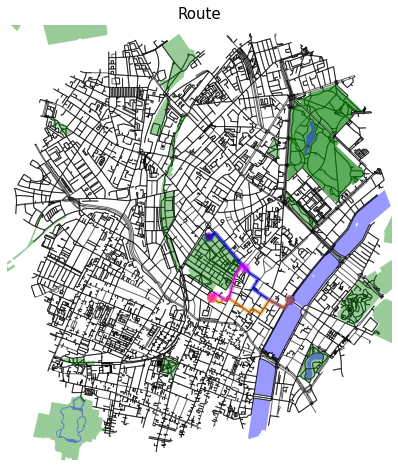

In [405]:
route1 = ox.shortest_path(U, orig_id, id_0, weight="length")
route2 = ox.shortest_path(U, id_0, id_1, weight="length")
route3 = ox.shortest_path(U, id_1, id_2, weight="length")

routes = [route1, route2, route3]

route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(U, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(U, route2, "length")))
route3_length = int(sum(ox.utils_graph.get_route_edge_attributes(U, route3, "length")))

print("The total route is", route1_length + route2_length + route3_length, "meters.")

# We plot the nodes which minimizes the distance to the coordinates to check that the method works
# create node weights 
node_weights = [50 if (node == orig_id) or (node == id_0) or (node == id_1) or (node == id_1) else 0 for node in U.nodes]

node_colours = [current_position_color if node == current_node else attraction_color if node == id_0 else bar_color if node == id_1 else restaurant_color if node == id_2 else 'white' for node in U.nodes]

fig, ax = ox.plot_graph_routes(U, routes, route_colors=[attraction_color, bar_color, restaurant_color], node_size=node_weights, node_color = node_colours,  edge_color="black", edge_linewidth=1, edge_alpha=0.6, bgcolor = 'white', show = False, close = False);

parks_subset.plot(color="green", linewidth=1, ax=ax, alpha = 0.4)
water_subset.plot(color="blue", linewidth=1, ax=ax, alpha = 0.4)


ax.set_title("Route", fontsize = 15)

plt.show()


# Making a new route with the new attributes

The total route is 3865 meters.


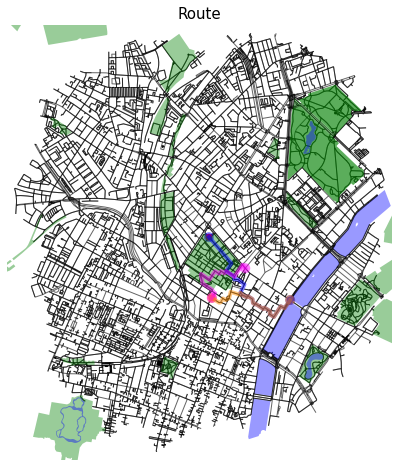

In [406]:
route1 = ox.shortest_path(U, orig_id, id_0, weight="total_cost")
route2 = ox.shortest_path(U, id_0, id_1, weight="total_cost")
route3 = ox.shortest_path(U, id_1, id_2, weight="total_cost")

routes = [route1, route2, route3]

route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(U, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(U, route2, "length")))
route3_length = int(sum(ox.utils_graph.get_route_edge_attributes(U, route3, "length")))

print("The total route is", route1_length + route2_length + route3_length, "meters.")

# We plot the nodes which minimizes the distance to the coordinates to check that the method works
# create node weights 
node_weights = [50 if (node == orig_id) or (node == id_0) or (node == id_1) or (node == id_1) else 0 for node in U.nodes]

node_colours = [current_position_color if node == current_node else attraction_color if node == id_0 else bar_color if node == id_1 else restaurant_color if node == id_2 else 'white' for node in U.nodes]

fig, ax = ox.plot_graph_routes(U, routes, route_colors=[attraction_color, bar_color, restaurant_color], node_size=node_weights, node_color = node_colours,  edge_color="black", edge_linewidth=1, edge_alpha=0.6, bgcolor = 'white', show = False, close = False);

parks_subset.plot(color="green", linewidth=1, ax=ax, alpha = 0.4)
water_subset.plot(color="blue", linewidth=1, ax=ax, alpha = 0.4)


ax.set_title("Route", fontsize = 15)

plt.show()
